In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [ ]:
# read imaging templates (only read once)
## check the ordering and resolution

# read galaxy and random
## apply required cuts
## project to healpix 

# construct the label and features 
# split into train, validation, and test

# perform training

# swap the weights

# derive the power spectrum

In [3]:
%matplotlib inline
import healpy as hp

In [4]:
import numpy as np
import fitsio as ft
import sys
sys.path.append('/home/mehdi/github/LSSutils')

In [5]:
from LSSutils.utils import hpixsum, makennbar

camb is not installed!


In [6]:
from LSSutils.stats.pcc import BTPCC, PCC

In [7]:
templates = ft.read('/home/mehdi/data/templates/SDSS_WISE_imageprop_nside512.fits')
templates.dtype.names

('NRAN',
 'SKY_G',
 'SKY_R',
 'SKY_I',
 'SKY_Z',
 'AIRMASS',
 'EBV',
 'DEPTH_G',
 'DEPTH_R',
 'DEPTH_I',
 'DEPTH_Z',
 'PSF_G',
 'PSF_R',
 'PSF_I',
 'PSF_Z',
 'W1_MED',
 'W1_COVMED',
 'W1_MOON',
 'STAR_DENSITY')

In [8]:
import matplotlib.pyplot as plt

In [9]:
from LSSutils.stats.nnbar import NNBAR

In [10]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('--- Systematic Weights ---')

In [11]:
logger.info('TEST')

INFO:--- Systematic Weights ---:TEST


In [91]:
class EbossCatalog:
    
    logger = logging.getLogger('EbossCatalog')
    
    def __init__(self, filename, kind='galaxy'):
        self.kind  = kind
        self.data  = ft.read(filename)
        
        self.select()
    
    def select(self, compmin=0.5, zmin=0.8, zmax=2.2):
        ''' `Full` to `Clustering` Catalog
        '''
        
        #-- apply cuts on galaxy or randoms
        if self.kind == 'galaxy':            
            
            # galaxy
            wd  = (self.data['IMATCH']==1) | (self.data['IMATCH']==2)
            wd &= (self.data['Z'] >= zmin) & (self.data['Z'] <= zmax)
            wd &= self.data['COMP_BOSS'] > compmin
            wd &= self.data['sector_SSR'] > compmin
            self.logger.info(f'{wd.sum()} galaxies pass the cuts')
            self.logger.info(f'% of galaxies after cut {np.mean(wd):0.2f}')
            self.data = self.data[wd]
            
        elif self.kind == 'random':
            
            # random
            wr  = (self.data['Z'] >= zmin) & (self.data['Z'] <= zmax)
            wr &= self.data['COMP_BOSS'] > compmin
            wr &= self.data['sector_SSR'] > compmin
            self.logger.info(f'{wr.sum()} randoms pass the cuts')
            self.logger.info(f'% of randoms after cut {np.mean(wr):0.2f}')        
            self.data = self.data[wr]
            
    
    def cutz(self, zlim):
        
        #datat = self.data.copy()
        
        zmin, zmax = zlim
        self.logger.info(f'Grab a slice with {zlim}')        
        myz   = (self.data['Z']>= zmin) & (self.data['Z']<= zmax)
        self.logger.info(f'# of data that pass this cut {myz.sum()}')
        self.cdata = self.data[myz]
        
    def tohp(self, nside):
        
        assert hasattr(self, 'cdata'), f'cdata not found'
        
        self.logger.info(f'Projecting to HEALPIX as {self.kind} with {nside}')
        
        if self.kind == 'galaxy':
            #weight = self.cdata['WEIGHT_CP']*self.cdata['WEIGHT_FKP']*self.cdata['WEIGHT_NOZ']
            weight = self.cdata['WEIGHT_CP']*self.cdata['WEIGHT_FKP']*self.cdata['WEIGHT_NOZ']*self.cdata['WEIGHT_SYSTOT']
        elif self.kind == 'random':
            #weight = self.cdata['COMP_BOSS']*self.cdata['WEIGHT_FKP']
            weight = self.cdata['WEIGHT_CP']*self.cdata['WEIGHT_FKP']*self.cdata['WEIGHT_NOZ']*self.cdata['WEIGHT_SYSTOT']
        else:
            raise ValueError(f'{self.kind} not defined')
            
        self.hpmap = hpixsum(nside, self.cdata['RA'], self.cdata['DEC'], value=weight)

In [106]:
class SystematicsTree:
    
    logger = logging.getLogger('SystematicsTree')
    
    def __init__(self, galaxy, random, templates, nside=512):
        self.galaxy    = galaxy
        self.random    = random
        self.templates = templates
        self.nside     = nside
        
    def _read_imaging(self, template_names=['EBV', 'DEPTH_G']):   
        self.logger.info(f'reading {template_names}')
        self.template_names = template_names
        
        #-- imaging maps
        x   = []
        nonan = np.ones(12*self.nside*self.nside, '?')
        for name_i in template_names:
            x_i = self.templates[name_i]
            nonan &= ~np.isnan(x_i)
            x.append(x_i)
        self.features = np.array(x).T        
        self.nonan    = nonan

        
    def combine(self, zlim, mask=None, 
                fracmin=0.2, select_fun=None,
               template_names=['EBV', 'DEPTH_G']):
        
        if not hasattr(self, 'features'):
            self._read_imaging(template_names=template_names)
            
        self.logger.info(f'Slice galaxy and randoms with `zlim` : {zlim}')
        
        #-- cut galaxy and random, and project to Healpix
        self.galaxy.cutz(zlim)
        self.galaxy.tohp(self.nside)
        
        self.random.cutz([0.8, 2.2])#zlim)
        self.random.tohp(self.nside)
        
        #-- apply a cut on the footprint
        self.mask = self.random.hpmap > fracmin
        if not mask is None:
            self.mask &= mask       
        self.mask &= self.nonan            
            
        #-- construct the N/Nbar map
        self.nnbar = makennbar(self.galaxy.hpmap, self.random.hpmap, self.mask,
                               select_fun=select_fun, is_sys=False)                
                
        self.logger.info(f'{self.mask.sum() - self.nonan.sum()} pixels removed due to nan imaging')
        
    def run_pcc(self, plot=False, title='TEST', figax=None):
        
        self.pcc  = PCC(self.features[MyTree.mask,:],   self.nnbar[self.mask])
        self.bpcc = BTPCC(self.features[MyTree.mask,:], self.nnbar[self.mask])
        
        if plot:
            if not figax is None:
                fig, ax = figax
            else:
                fig, ax = plt.subplots()
            
            x = np.arange(len(self.pcc))
            prcntiles = np.percentile(self.bpcc, [0.5, 99.5], axis=0)
            
            #ax.bar(x, self.pcc, color='crimson', alpha=0.5)
            #ax.fill_between(x, y1=prcntiles[0], y2=prcntiles[1], alpha=0.2, color='b')
            ax.errorbar(x, np.zeros_like(x), 
                        yerr=[-prcntiles[0], prcntiles[1]], 
                        alpha=1., color='grey',
                        ls='None', capsize=5)

            ax.scatter(x, self.pcc, 80, color='red',
                       alpha=0.8, marker='o')
            
            ax.set_xticks(x)
            ax.grid(True, ls=':', color='grey')
            ax.set_xticklabels(self.template_names, rotation=90)
            ax.set(ylabel='PCC')
            ax.axhline(0, color='k')
            ax.text(0.1, 0.9, title, transform=ax.transAxes)
            
            
    def run_nnbar(self, nbins=8, njack=20, plot=False):
        
        self.logger.info(f'nbins={nbins} njack={njack}')
        self.nnbar = {}
        
        for name_i in self.template_names:
            
            self.logger.info(f'run NNBAR on {name_i}')
            
            #--- no weight
            nnbar_i = NNBAR(self.galaxy.hpmap, self.random.hpmap,
                            self.mask, self.templates[name_i],
                            nbins=nbins)
            nnbar_i.run(njack=njack)            
            self.nnbar[name_i] = {'No Weight':nnbar_i.output}
            
        if plot:
            ncols=len(self.nnbar)
            fig, ax = plt.subplots(1, ncols=ncols, figsize=(6*ncols, 4),
                                  sharey=True)
            fig.subplots_adjust(wspace=0.0)
            for i,keyi in enumerate(self.nnbar):
                for j, keyj in enumerate(self.nnbar[keyi]):                    
                    output_i = self.nnbar[keyi][keyj]
                    x  = 0.5*(output_i['bin_edges'][1:]+output_i['bin_edges'][:-1])
                    y  = output_i['nnbar']
                    ye = output_i['nnbar_err']

                    ax[i].errorbar(x, y, yerr=ye, ls='-', color='k', label=keyj)
                ax[i].set(xlabel=keyi)
                ax[i].grid(True, ls=':', color='grey')
                if i==0:ax[0].legend()

In [107]:
#--- read galaxy and random 
galaxy = EbossCatalog('/home/mehdi/data/eboss/v7_1/eBOSS_QSO_full_NGC_v7_1.dat.fits', 'galaxy')
random = EbossCatalog('/home/mehdi/data/eboss/v7_1/eBOSS_QSO_full_NGC_v7_1.ran.fits', 'random')

INFO:EbossCatalog:218202 galaxies pass the cuts
INFO:EbossCatalog:% of galaxies after cut 0.54
INFO:EbossCatalog:11096305 randoms pass the cuts
INFO:EbossCatalog:% of randoms after cut 0.64


In [130]:
zcuts     = {'0.8': [0.80, 1.14],
             '1.1': [1.14, 1.39],
             '1.4': [1.39, 1.63],
             '1.6': [1.63, 1.88],
             '1.9': [1.88, 2.20]}
# zcuts     = {'0.8': [0.80, 1.5],
#              '1.5': [1.5, 2.2]}

INFO:SystematicsTree:reading ['EBV', 'DEPTH_G']
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [0.8, 1.14]
INFO:EbossCatalog:Grab a slice with [0.8, 1.14]


0.8 [0.8, 1.14]


INFO:EbossCatalog:# of data that pass this cut 43265
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]
INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [1.14, 1.39]
INFO:EbossCatalog:Grab a slice with [1.14, 1.39]
INFO:EbossCatalog:# of data that pass this cut 44685
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]


1.1 [1.14, 1.39]


INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [1.39, 1.63]
INFO:EbossCatalog:Grab a slice with [1.39, 1.63]
INFO:EbossCatalog:# of data that pass this cut 42558
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]


1.4 [1.39, 1.63]


INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [1.63, 1.88]
INFO:EbossCatalog:Grab a slice with [1.63, 1.88]
INFO:EbossCatalog:# of data that pass this cut 43594
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]


1.6 [1.63, 1.88]


INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [1.88, 2.2]
INFO:EbossCatalog:Grab a slice with [1.88, 2.2]
INFO:EbossCatalog:# of data that pass this cut 44100
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]


1.9 [1.88, 2.2]


INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging


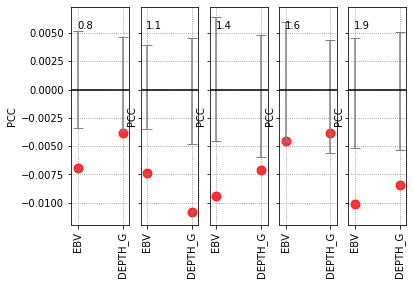

In [137]:
fig, ax = plt.subplots(ncols=5, sharey=True)
MyTree = SystematicsTree(galaxy, random, templates)
for i,key in enumerate(zcuts.keys()):
    print(key, zcuts[key])
    MyTree.combine(zcuts[key])
    MyTree.run_pcc(plot=True, figax=(fig, ax[i]), title=key)

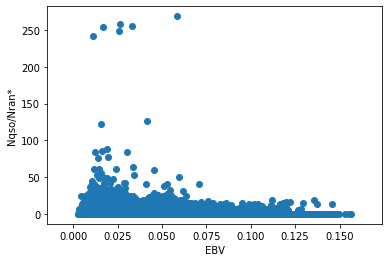

In [135]:
plt.xlabel('EBV')
plt.ylabel('Nqso/Nran*')
plt.scatter(MyTree.features[MyTree.mask,0], MyTree.nnbar[MyTree.mask])

Text(0, 0.5, 'Npix')

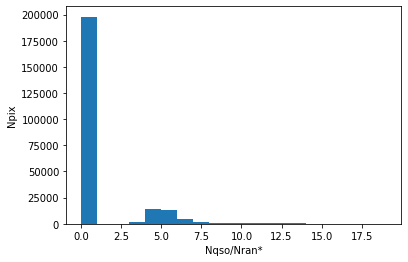

In [136]:
_=plt.hist(MyTree.nnbar[MyTree.mask], bins=[0, 1]+[i for i in range(2, 20)])
plt.xlabel('Nqso/Nran*')
plt.ylabel('Npix')

INFO:SystematicsTree:reading ['EBV', 'DEPTH_G']
INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [0.8, 2.2]
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]
INFO:EbossCatalog:# of data that pass this cut 218202


0.8 [0.8, 2.2]


INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]
INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:-586686 pixels removed due to nan imaging


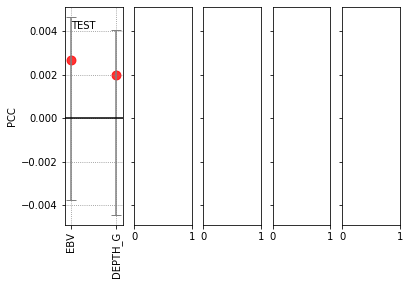

In [85]:
zcuts     = {'0.8': [0.80, 2.2]}
fig, ax = plt.subplots(ncols=5, sharey=True)
MyTree = SystematicsTree(galaxy, random, templates)
for i,key in enumerate(zcuts.keys()):
    print(key, zcuts[key])
    MyTree.combine(zcuts[key])
    MyTree.run_pcc(plot=True, figax=(fig, ax[i]))

In [59]:
MyTree.combine([0.8, 2.2])

INFO:SystematicsTree:Slice galaxy and randoms with `zlim` : [0.8, 2.2]
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]
INFO:EbossCatalog:# of data that pass this cut 218202
INFO:EbossCatalog:Projecting to HEALPIX as galaxy with 512
INFO:EbossCatalog:Grab a slice with [0.8, 2.2]
INFO:EbossCatalog:# of data that pass this cut 11096305
INFO:EbossCatalog:Projecting to HEALPIX as random with 512
INFO:SystematicsTree:43 pixels removed due to nan imaging


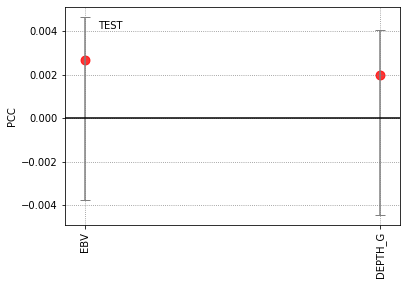

In [60]:
MyTree.run_pcc(plot=True)

INFO:SystematicsTree:nbins=8 njack=20
INFO:SystematicsTree:run NNBAR on EBV
INFO:SystematicsTree:run NNBAR on DEPTH_G


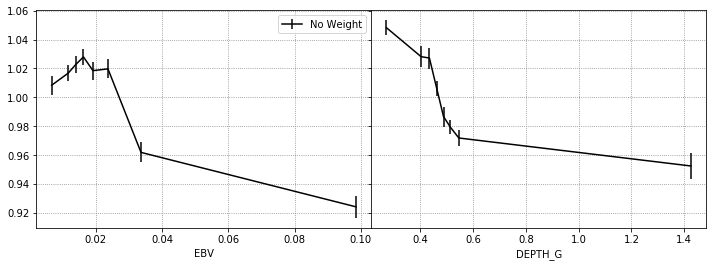

In [120]:
MyTree.run_nnbar(plot=True)

In [121]:
from sklearn.neural_network import MLPRegressor

In [122]:
help(MLPRegressor)

Help on class MLPRegressor in module sklearn.neural_network.multilayer_perceptron:

class MLPRegressor(BaseMultilayerPerceptron, sklearn.base.RegressorMixin)
 |  MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
 |  
 |  Multi-layer Perceptron regressor.
 |  
 |  This model optimizes the squared-loss using LBFGS or stochastic gradient
 |  descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logistic', 'tanh', 'relu'

In [20]:
#np.percentile(galaxy['Z'], [0, 25, 50, 75, 100])
# [0.80001524, 1.20787712, 1.50846194, 1.81560686, 2.19999942]
selection_mask = {
                  'z0':{'zlim':(0.8, 1.2), 'model':None},
                  'z1':{'zlim':(1.2, 1.5), 'model':None},
                  'z2':{'zlim':(1.5, 1.8), 'model':None},
                  'z3':{'zlim':(1.8, 2.2), 'model':None}
                 }
selection_mask

{'z0': {'zlim': (0.8, 1.2), 'model': None},
 'z1': {'zlim': (1.2, 1.5), 'model': None},
 'z2': {'zlim': (1.5, 1.8), 'model': None},
 'z3': {'zlim': (1.8, 2.2), 'model': None}}

In [55]:
cgalaxy.cutz([0.8, 1.2])
cgalaxy.tohp(512)

INFO:--- Systematic Weights ---:Grab a slice with [0.8, 1.2]
INFO:--- Systematic Weights ---:# of data that pass this cut 53176
INFO:--- Systematic Weights ---:Projecting to HEALPIX as galaxy with 512


In [32]:
hpixsum

<function LSSutils.utils.hpixsum(nside, ra, dec, value=None, nest=False)>

In [41]:
%matplotlib inline

In [39]:
import healpy as hp

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


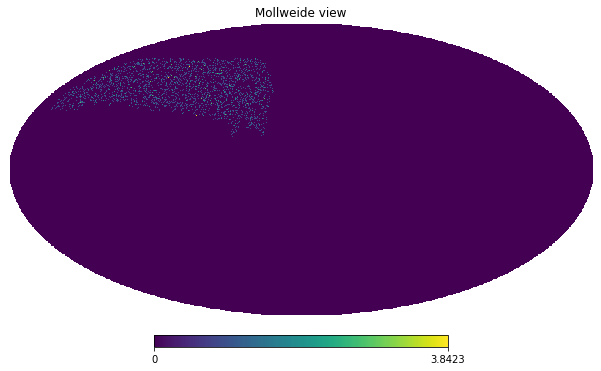

In [56]:
hp.mollview(cgalaxy.hpmap, rot=90)